Sampling Rate: 16000
Total Samples: 72003


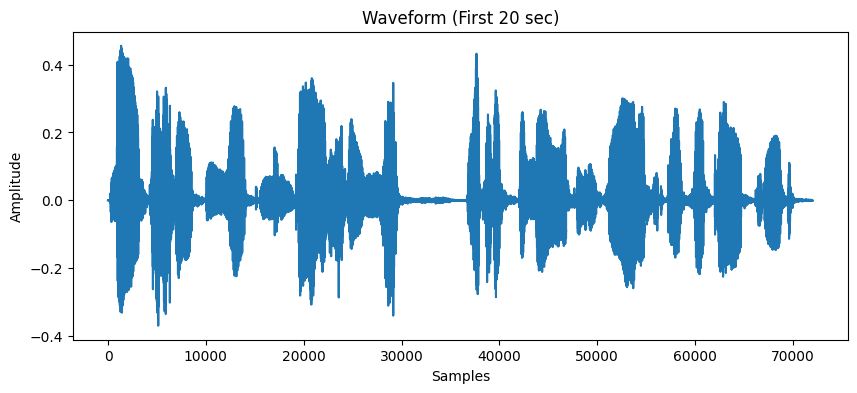

Frame Length: 400
Frame Shift: 160
Total Frames: 448


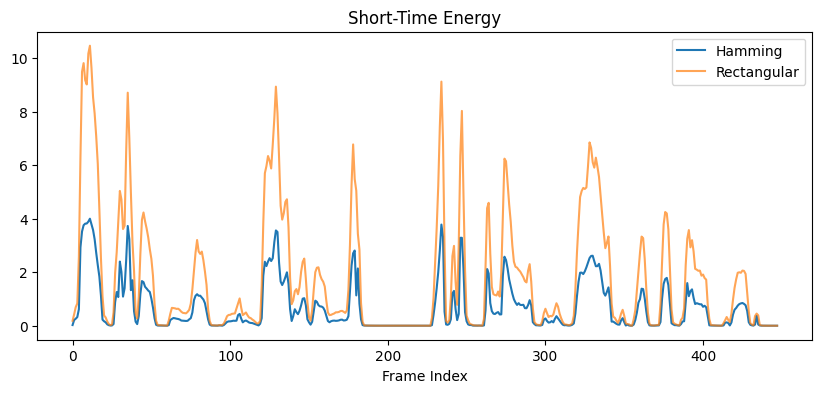

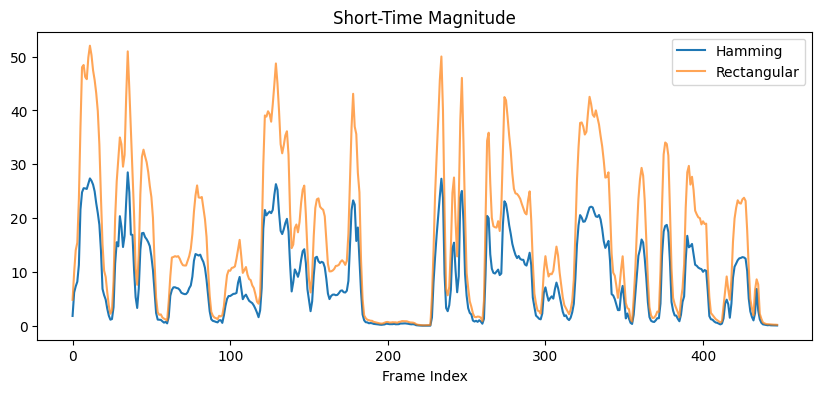

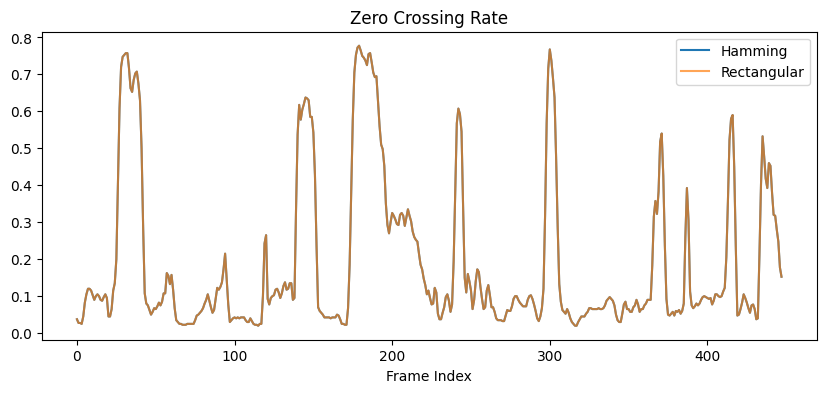

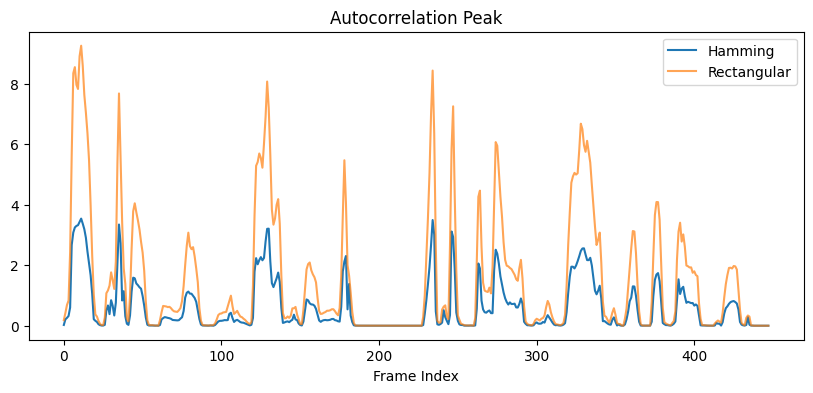

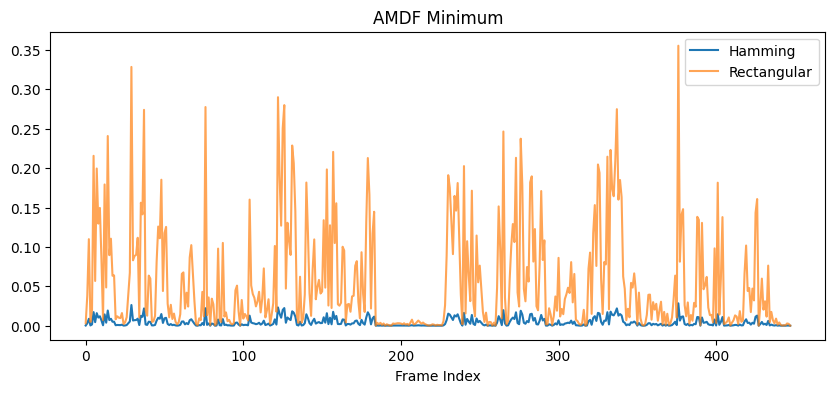

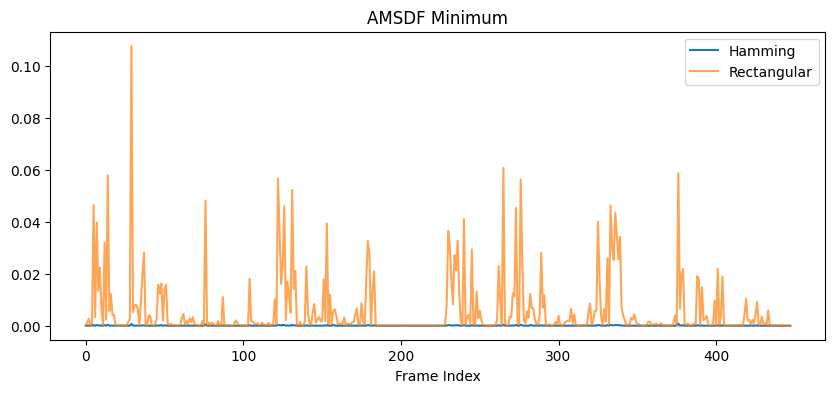

Number of Periodic (Voiced) Frames: 433
First 10 Estimated Pitch Values (Hz):
[np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0), np.float64(16000.0)]


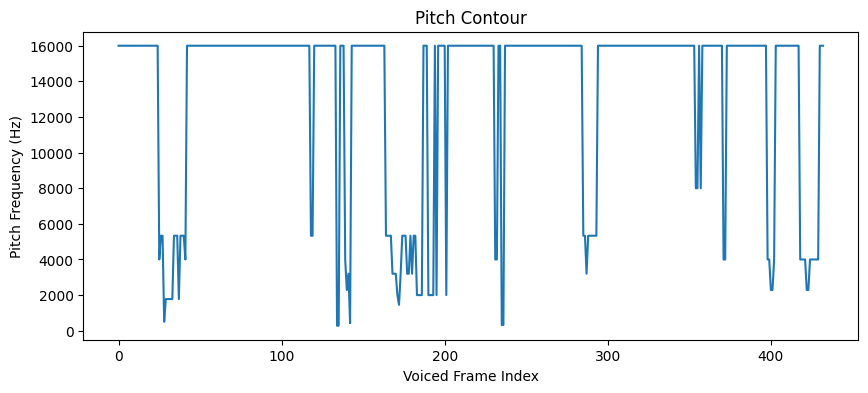

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

audio_path = "/content/LJ050-0274.wav"  # change file path
signal, sr = librosa.load(audio_path, sr=16000)

signal = signal[:20 * sr]  # first 20 seconds

print("Sampling Rate:", sr)
print("Total Samples:", len(signal))

plt.figure(figsize=(10,4))
plt.plot(signal)
plt.title("Waveform (First 20 sec)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# 2. FRAME PARAMETERS


frame_length = int(0.025 * sr)  # 25 ms
frame_shift = int(0.010 * sr)   # 10 ms

num_frames = int((len(signal) - frame_length) / frame_shift) + 1

print("Frame Length:", frame_length)
print("Frame Shift:", frame_shift)
print("Total Frames:", num_frames)


# 3. FRAMING


frames = []
for i in range(num_frames):
    start = i * frame_shift
    end = start + frame_length
    frames.append(signal[start:end])

frames = np.array(frames)

# 4. WINDOW FUNCTIONS


hamming = np.hamming(frame_length)
rectangular = np.ones(frame_length)

# 5. FEATURE FUNCTIONS

def short_time_energy(x):
    return np.sum(x**2)

def short_time_magnitude(x):
    return np.sum(np.abs(x))

def zero_crossing_rate(x):
    return np.sum(np.abs(np.diff(np.sign(x)))) / (2*len(x))

def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def amdf(x):
    N = len(x)
    values = []
    for k in range(N):
        values.append(np.sum(np.abs(x[:N-k] - x[k:])))
    return np.array(values)

def amsdf(x):
    N = len(x)
    values = []
    for k in range(N):
        values.append(np.sum((x[:N-k] - x[k:])**2))
    return np.array(values)

# 6. FEATURE EXTRACTION FUNCTION


def extract_features(frames, window):

    STE, STM, ZCR = [], [], []
    AC, AMDF_list, AMSDF_list = [], [], []

    for frame in frames:
        w = frame * window

        STE.append(short_time_energy(w))
        STM.append(short_time_magnitude(w))
        ZCR.append(zero_crossing_rate(w))

        ac = autocorrelation(w)
        amdf_val = amdf(w)
        amsdf_val = amsdf(w)

        # Take only first non-zero lag peak/minimum
        AC.append(np.max(ac[1:]))
        AMDF_list.append(np.min(amdf_val[1:]))
        AMSDF_list.append(np.min(amsdf_val[1:]))

    return np.array(STE), np.array(STM), np.array(ZCR), \
           np.array(AC), np.array(AMDF_list), np.array(AMSDF_list)

# Extract for both windows
STE_h, STM_h, ZCR_h, AC_h, AMDF_h, AMSDF_h = extract_features(frames, hamming)
STE_r, STM_r, ZCR_r, AC_r, AMDF_r, AMSDF_r = extract_features(frames, rectangular)

# 7. PLOT ALL 6 FEATURES (Both Windows)


def plot_feature(f1, f2, title):
    plt.figure(figsize=(10,4))
    plt.plot(f1, label="Hamming")
    plt.plot(f2, label="Rectangular", alpha=0.7)
    plt.title(title)
    plt.xlabel("Frame Index")
    plt.legend()
    plt.show()

plot_feature(STE_h, STE_r, "Short-Time Energy")
plot_feature(STM_h, STM_r, "Short-Time Magnitude")
plot_feature(ZCR_h, ZCR_r, "Zero Crossing Rate")
plot_feature(AC_h, AC_r, "Autocorrelation Peak")
plot_feature(AMDF_h, AMDF_r, "AMDF Minimum")
plot_feature(AMSDF_h, AMSDF_r, "AMSDF Minimum")

# 8. PERIODICITY ANALYSIS


periodic_frames = []

for i in range(len(AC_h)):
    if AC_h[i] > 0.3 * STE_h[i]:  # voiced detection rule
        periodic_frames.append(i)

print("Number of Periodic (Voiced) Frames:", len(periodic_frames))

# 9. PITCH ESTIMATION


pitch_values = []

for i in periodic_frames:

    frame = frames[i] * hamming
    ac = autocorrelation(frame)
    ac[0] = 0

    lag = np.argmax(ac)
    if lag != 0:
        pitch = sr / lag
        pitch_values.append(pitch)

print("First 10 Estimated Pitch Values (Hz):")
print(pitch_values[:10])

plt.figure(figsize=(10,4))
plt.plot(pitch_values)
plt.title("Pitch Contour")
plt.xlabel("Voiced Frame Index")
plt.ylabel("Pitch Frequency (Hz)")
plt.show()